In [98]:
import torch
import torchvision
import torchmetrics
import lightning as L
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Using Pytorch Lightning to Train CNN on MNIST Dataset

In [4]:
dataset = torchvision.datasets.MNIST(os.getcwd(), download=True, transform=torchvision.transforms.ToTensor())

Let's split the dataset into training, validation, and test splits.

In [5]:
generator = torch.Generator().manual_seed(42)
train, val, test = torch.utils.data.random_split(dataset=dataset, lengths=[0.8, 0.1, 0.1], generator=generator)

In [6]:
print(f'Length of training dataset: {len(train)}')
print(f' Length of validation dataset: {len(val)}')
print(f'Length of test dataset: {len(test)}')

Length of training dataset: 48000
 Length of validation dataset: 6000
Length of test dataset: 6000


In [215]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=7)
validation_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=False, num_workers=7)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False, num_workers=7)

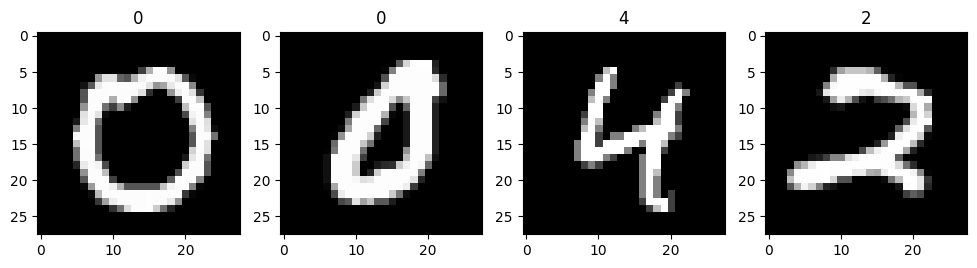

In [8]:
images, labels = next(iter(train_loader))
images.shape
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12,7))
axes[0].imshow(images[0].squeeze(), cmap='gray')
axes[0].title.set_text(labels[0].item())
axes[1].imshow(images[-1].squeeze(), cmap='gray')
axes[1].title.set_text(labels[-1].item())
axes[2].imshow(images[15].squeeze(), cmap='gray')
axes[2].title.set_text(labels[15].item())
axes[3].imshow(images[6].squeeze(), cmap='gray')
axes[3].title.set_text(labels[6].item())

# Define the model

In [167]:

class DigitClassifier(L.LightningModule):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(num_channels, 32, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(32, 54, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(54*7*7, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, num_classes)
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.classification.Accuracy(task='multiclass',
                                                             num_classes=num_classes)
        self.f1_score = torchmetrics.F1Score(task='multiclass', num_classes=num_classes)
        self.test_step_outputs = []

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        #flatten tensor
        x = x.view(-1, 54*7*7)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        # x, y = batch
        # # flatten input tensor
        # x = x.view(x.size(0), -1)
        # scores = self.forward(x)
        # loss = self.loss_function(scores, y)
        loss, scores, y = self._common_step(batch, batch_idx)
        # self.log is a built-in function inherited from the LightningModule object.
        # It lets us keep track of certain metrics during training, etc.
        accuracy = self.accuracy(scores, y)
        f1_score = self.f1_score(scores, y)
        self.log_dict({'training_loss': loss, 'train_accuracy':accuracy, 'train_f1_score':f1_score},
                      on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.log('training_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # # same as training step
        # x, y = batch
        # # flatten input tensor
        # x = x.view(x.size(0), -1)
        # scores = self.forward(x)
        # loss = self.loss_function(scores, y)
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        f1_score = self.f1_score(scores, y)
        self.log_dict({'val_loss': loss, 'val_accuracy':accuracy, 'val_f1_score':f1_score},
                      on_step=False, on_epoch=True, prog_bar=True, logger=True)
        #self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # # same as training step
        # x, y = batch
        # # flatten input tensor
        # x = x.view(x.size(0), -1)
        # scores = self.forward(x)
        # loss = self.loss_function(scores, y)
        loss, scores, y = self._common_step(batch, batch_idx)
        accuracy = self.accuracy(scores, y)
        f1_score = self.f1_score(scores, y)
        #self.log('test_loss', loss)
        self.log_dict({'test_loss': loss, 'test_accuracy':accuracy, 'test_f1_score':f1_score,},
                       on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #outputs = {'loss':loss, 'test_scores': scores, 'test_labels': y}
        return loss

    def _common_step(self, batch, batch_idx):
        # same as training, val, and test, but combined into one for simplicity
        x, y = batch
        scores = self.forward(x)
        loss = self.loss_function(scores, y)
        return loss, scores, y

    def predict_step(self, batch, batch_idx):
        x, y = batch
        #x = x.view(x.size(0), -1)
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        return preds


    def configure_optimizers(self):
        # you could also include a scheduler here
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [71]:
#images[0].view(28,28).size()

torch.Size([28, 28])

In [113]:
model = DigitClassifier(num_channels=1, num_classes=10)

In [105]:
if torch.backends.mps.is_available():
    print('MPS Detected')
else:
    print('No MPS detected')

MPS Detected


In [114]:
trainer = L.Trainer(accelerator='mps', min_epochs=1, max_epochs=4, check_val_every_n_epoch=1)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params
------------------------------------------------------------
0 | conv1         | Conv2d                    | 320   
1 | pool          | MaxPool2d                 | 0     
2 | conv2         | Conv2d                    | 15.6 K
3 | fc1           | Linear                    | 317 K 
4 | fc2           | Linear                    | 10.2 K
5 | fc3           | Linear                    | 850   
6 | loss_function | CrossEntropyLoss          | 0     
7 | accuracy      | MulticlassAccuracy        | 0     
8 | f1_score      | MulticlassF1Score         | 0     
9 | confusion_mat | MulticlassConfusionMatrix | 0     
------------------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params
1.378     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/pytorch_lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/pytorch_lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 3: 100%|██████████| 1500/1500 [00:32<00:00, 45.53it/s, v_num=8, training_loss_step=0.101, train_accuracy_step=0.969, train_f1_score_step=0.969, val_loss=0.0431, val_accuracy=0.987, val_f1_score=0.987, training_loss_epoch=0.0318, train_accuracy_epoch=0.989, train_f1_score_epoch=0.989]   

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1500/1500 [00:32<00:00, 45.50it/s, v_num=8, training_loss_step=0.101, train_accuracy_step=0.969, train_f1_score_step=0.969, val_loss=0.0431, val_accuracy=0.987, val_f1_score=0.987, training_loss_epoch=0.0318, train_accuracy_epoch=0.989, train_f1_score_epoch=0.989]


In [115]:
log_dict_logs_df = pd.read_csv('/Users/ryantenbarge/code/playground/pytorch_lightning_practice/lightning_logs/version_8/metrics.csv')
log_dict_logs_df

,epoch,step,train_accuracy_epoch,train_accuracy_step,train_f1_score_epoch,train_f1_score_step,training_loss_epoch,training_loss_step,val_accuracy,val_f1_score,val_loss
0,0,49,NaN,0.65625,NaN,0.65625,NaN,0.946451,NaN,NaN,NaN
1,0,99,NaN,0.90625,NaN,0.90625,NaN,0.247330,NaN,NaN,NaN
2,0,149,NaN,0.90625,NaN,0.90625,NaN,0.342587,NaN,NaN,NaN
3,0,199,NaN,0.96875,NaN,0.96875,NaN,0.161464,NaN,NaN,NaN
4,0,249,NaN,0.81250,NaN,0.81250,NaN,0.577978,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
123,3,5899,NaN,1.00000,NaN,1.00000,NaN,0.005849,NaN,NaN,NaN
124,3,5949,NaN,1.00000,NaN,1.00000,NaN,0.001007,NaN,NaN,NaN
125,3,5999,NaN,0.96875,NaN,0.96875,NaN,0.101350,NaN,NaN,NaN
126,3,5999,NaN,NaN,NaN,NaN,NaN,NaN,0.986667,0.986667,0.04308


In [121]:
train_acc_df = log_dict_logs_df[~log_dict_logs_df['train_accuracy_epoch'].isna()][['epoch', 'train_accuracy_epoch']]
val_acc_df = log_dict_logs_df[~log_dict_logs_df['val_accuracy'].isna()][['epoch', 'val_accuracy']]
val_acc_df
train_acc_df

,epoch,train_accuracy_epoch
31,0,0.930833
63,1,0.981333
95,2,0.986854
127,3,0.989438


Text(0.5, 1.0, 'Model Accuracy Over Epoch')

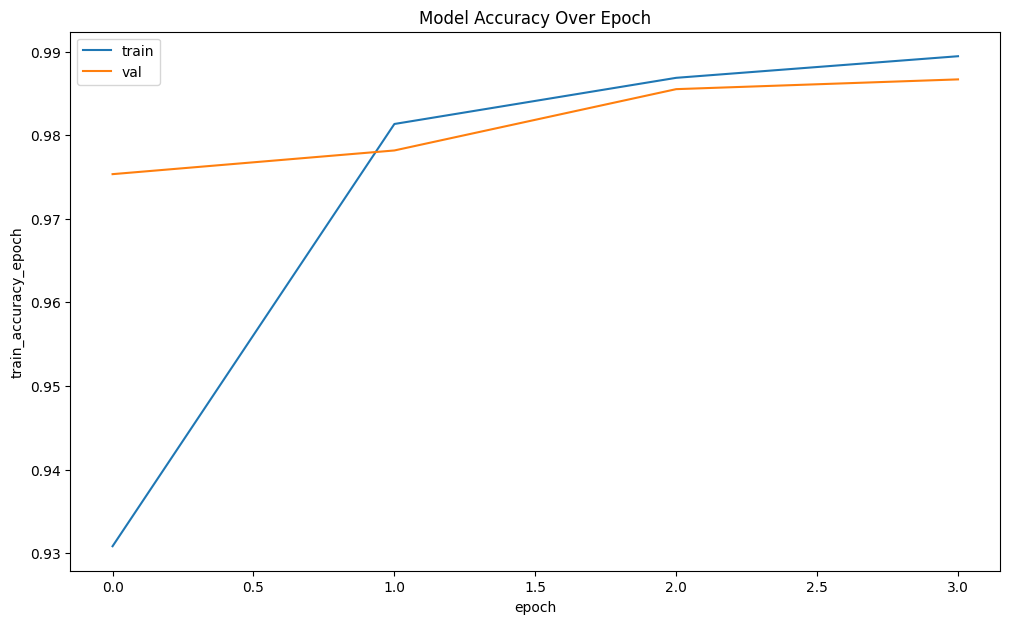

In [124]:
plt.figure(figsize=(12,7))
sns.lineplot(data=train_acc_df, x='epoch', y='train_accuracy_epoch', label='train')
sns.lineplot(data=val_acc_df, x='epoch', y='val_accuracy', label='val')
plt.title('Model Accuracy Over Epoch')

# View Training Loss

In [89]:
training_loss_df = pd.read_csv(os.path.join(os.getcwd(), 'lightning_logs', 'version_7', 'metrics.csv'))
training_loss_df.head()

,epoch,step,training_loss,val_loss
0,0,49,1.073526,NaN
1,0,99,0.261219,NaN
2,0,149,0.470168,NaN
3,0,199,0.292731,NaN
4,0,249,0.126708,NaN


In [90]:
training_losses = training_loss_df[~training_loss_df['training_loss'].isna()]
training_losses.shape

(450, 4)

In [91]:
validation_losses = training_loss_df[~training_loss_df['val_loss'].isna()][['epoch', 'val_loss']]
validation_losses

,epoch,val_loss
30,0,0.066851
61,1,0.048563
92,2,0.044698
123,3,0.045582
154,4,0.051306
185,5,0.039716
216,6,0.047193
247,7,0.053845
278,8,0.039609
309,9,0.044245


/var/folders/vn/13psflc51r9239vr17gr6rxw0000gn/T/ipykernel_1946/1293444476.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=training_losses, x='epoch', y='training_loss', label='train', ci=None)


Text(0.5, 1.0, 'Training Loss Over Epoch')

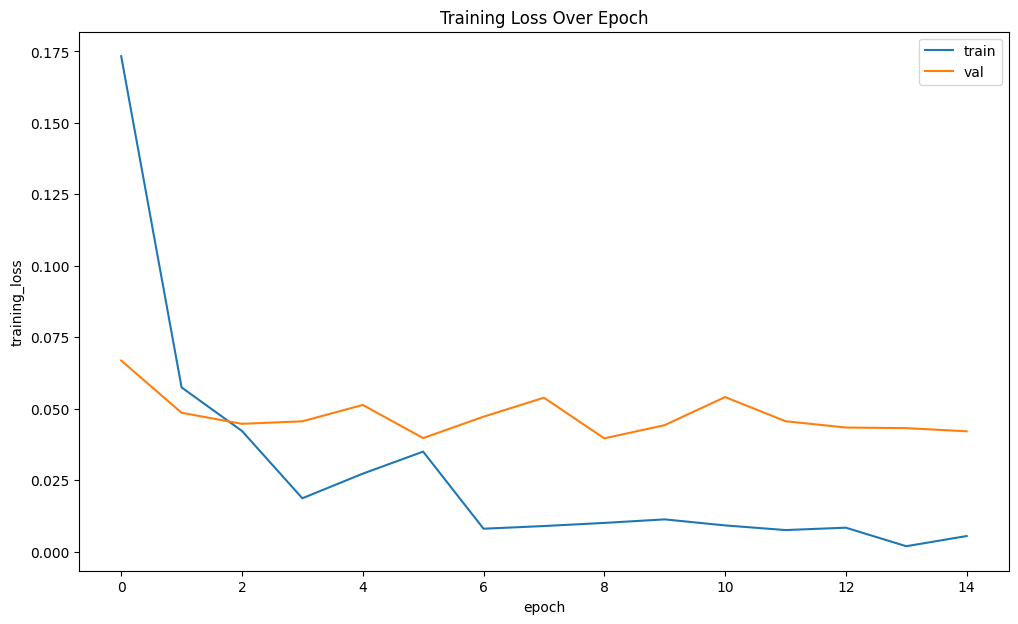

In [93]:
plt.figure(figsize=(12,7))
sns.lineplot(data=training_losses, x='epoch', y='training_loss', label='train', ci=None)
sns.lineplot(data=validation_losses, x='epoch', y='val_loss', label='val')
plt.title('Training Loss Over Epoch')

Given the above loss curves, it seems like stopping around 5 epochs may be best to avoid overfitting.

In [160]:
model = DigitClassifier(num_channels=1, num_classes=10)

In [127]:
trainer = L.Trainer(accelerator='mps', min_epochs=1, max_epochs=5, check_val_every_n_epoch=1)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params
------------------------------------------------------------
0 | conv1         | Conv2d                    | 320   
1 | pool          | MaxPool2d                 | 0     
2 | conv2         | Conv2d                    | 15.6 K
3 | fc1           | Linear                    | 317 K 
4 | fc2           | Linear                    | 10.2 K
5 | fc3           | Linear                    | 850   
6 | loss_function | CrossEntropyLoss          | 0     
7 | accuracy      | MulticlassAccuracy        | 0     
8 | f1_score      | MulticlassF1Score         | 0     
9 | confusion_mat | MulticlassConfusionMatrix | 0     
------------------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params
1.378     Total estimated model params s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/pytorch_lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/pytorch_lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 4: 100%|██████████| 1500/1500 [00:32<00:00, 46.44it/s, v_num=9, training_loss_step=0.0187, train_accuracy_step=1.000, train_f1_score_step=1.000, val_loss=0.0379, val_accuracy=0.990, val_f1_score=0.990, training_loss_epoch=0.0217, train_accuracy_epoch=0.993, train_f1_score_epoch=0.993]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1500/1500 [00:32<00:00, 46.42it/s, v_num=9, training_loss_step=0.0187, train_accuracy_step=1.000, train_f1_score_step=1.000, val_loss=0.0379, val_accuracy=0.990, val_f1_score=0.990, training_loss_epoch=0.0217, train_accuracy_epoch=0.993, train_f1_score_epoch=0.993]


# Loading in Model from Checkpoint

In [147]:
checkpoint_path = '/Users/ryantenbarge/code/playground/pytorch_lightning_practice/lightning_logs/version_9/checkpoints/epoch=4-step=7500.ckpt'

In [168]:
model = DigitClassifier.load_from_checkpoint(checkpoint_path=checkpoint_path,
                                             num_channels=1, num_classes=10)

# Evaluate the Model on Test Set

In [162]:
results = trainer.test(model=model, dataloaders=test_loader)
results

/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/pytorch_lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/pytorch_lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [01:18<?, ?it/s]
Testing: |          | 188/? [00:04<00:00, 42.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_accuracy_epoch      0.9858333468437195
   test_f1_score_epoch      0.9858333468437195
     test_loss_epoch       0.051036182790994644
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.051036182790994644,
  'test_accuracy_epoch': 0.9858333468437195,
  'test_f1_score_epoch': 0.9858333468437195}]

In [209]:
preds = trainer.predict(model=model, dataloaders=test_loader)
type(preds)

Predicting DataLoader 0: 100%|██████████| 188/188 [00:00<00:00, 225.16it/s]


list

In [210]:
preds = [tensor.tolist() for tensor in preds]

In [211]:
preds = np.array([item for lst in preds for item in lst])
preds.shape

(6000,)

In [212]:
targets = [label for feature, label in test]
targets = np.array(targets)
targets.shape

(6000,)